In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
import cartopy.crs as ccrs
import geopandas as gpd

Plotar o mapa e salvar a figura

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\usuario\AppData\Local\Temp\ipykernel_8556\2998967404.py:8: SyntaxWarning: invalid escape sequence '\l'
  lat_sismos, lon_sismos = np.loadtxt('lab-geo-22-09\loc_sismos.txt', usecols=(0,1), unpack=True)
C:\Users\usuario\AppData\Local\Temp\ipykernel_8556\2998967404.py:8: SyntaxWarning: invalid escape sequence '\l'
  lat_sismos, lon_sismos = np.loadtxt('lab-geo-22-09\loc_sismos.txt', usecols=(0,1), unpack=True)


CRSError: Invalid projection: EPSG:4326: (Internal Proj Error: proj_create: no database context specified)

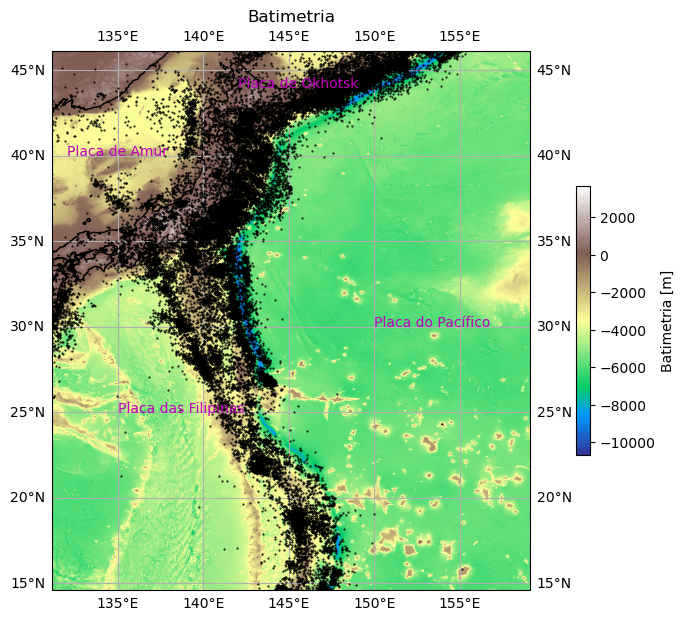

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
import cartopy.crs as ccrs
import geopandas as gpd

lat_sismos, lon_sismos = np.loadtxt('lab-geo-22-09\loc_sismos.txt', usecols=(0,1), unpack=True)

with rasterio.open(r'D:\chagasluffypalmeiras\lab-geo-22-09\exportImage(4).tiff') as src: 
    bounds = src.bounds #limites espaciais da imagem
    img = src.read(1)
    transform = src.transform #convertendo de coordenada de pixel para coordenada real
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

   
    if src.crs is not None and not src.crs.is_geographic:
        lon_min, lat_min, lon_max, lat_max = transform_bounds(
            src.crs, "EPSG:4326", bounds.left, bounds.bottom, bounds.right, bounds.top, densify_pts=21
        )
    else:
        lon_min, lon_max = bounds.left, bounds.right
        lat_min, lat_max = bounds.bottom, bounds.top


fig = plt.figure(figsize=(12,7))
ax = plt.axes(projection=ccrs.PlateCarree()) #projeção para a imagem que estamos criando

ax.set_extent([lon_min, lon_max-8, lat_min, lat_max], crs=ccrs.PlateCarree()) #definindo o recorte do mapa para focar na nossa área

mapinha = plt.imshow(img, origin='upper', extent=extent, transform=ccrs.PlateCarree(),cmap='terrain', interpolation='nearest')

#cmap = 'BrBg' - marram para azul
#cmap = 'terrain' -  marrom-esverdeado para azul
#cmap = 'copper' - tons de cobre
#cmap = 'PuOr - roxo-alaranjado
#cmap = 'spectral' - escala colorida
#cmap = 'Blues_r' - tons de azul

ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(mapinha, shrink = 0.5)
cbar.set_label('Batimetria [m]')

plt.title('Batimetria')

plt.plot(lon_sismos, lat_sismos, 'ko', markersize=0.5)


plt.text(142, 44, 'Placa de Okhotsk', color ='m')

plt.text(150, 30, 'Placa do Pacífico' ,color ='m')

plt.text(135, 25,  'Placa das Filipinas', color= 'm')

plt.text(132, 40,  'Placa de Amur', color = 'm')

placas = gpd.read_file(r'D:\chagasluffypalmeiras\lab-geo-22-09\PB2002_boundaries.shp')
placas.plot(ax=ax, color='red', linewidth=1, transform=ccrs.PlateCarree())
#plt.text(-40, -35.8, 'Placa Sul-Americana')
#plt.text(0, -35.8, 'Placa Africana')
plt.savefig('gebco.png',dpi=300)





Ver os limites geográficos 

In [3]:
print(f"CRS: {src.crs}")
print(f"extent (imagem): {extent}")
print(f"lon_min={lon_min:.6f}, lon_max={lon_max:.6f}")
print(f"lat_min={lat_min:.6f}, lat_max={lat_max:.6f}")

CRS: EPSG:4326
extent (imagem): [131.14583, 167.09167, 14.604163742900191, 46.1333362570998]
lon_min=131.145830, lon_max=167.091670
lat_min=14.604164, lat_max=46.133336


Plotar o mapa e salvar xyz

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
import cartopy.crs as ccrs
import geopandas as gpd

# >>> ADIÇÃO: para transformar coordenadas caso o TIFF esteja projetado
from pyproj import Transformer
from rasterio.transform import xy as transform_xy
# <<<

lat_sismos, lon_sismos = np.loadtxt('lab-geo-22-09\loc_sismos.txt', usecols=(0,1), unpack=True)

with rasterio.open(r'D:\chagasluffypalmeiras\lab-geo-22-09\GEBCO_22_Sep_2025_029245bf3f7c\gebco_2025_n39.3_s31.875_w134.1333_e143.975.tif') as src: 
    bounds = src.bounds #limites espaciais da imagem
    img = src.read(1)
    transform = src.transform #convertendo de coordenada de pixel para coordenada real
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    if src.crs is not None and not src.crs.is_geographic:
        lon_min, lat_min, lon_max, lat_max = transform_bounds(
            src.crs, "EPSG:4326", bounds.left, bounds.bottom, bounds.right, bounds.top, densify_pts=21
        )
    else:
        lon_min, lon_max = bounds.left, bounds.right
        lat_min, lat_max = bounds.bottom, bounds.top

    # >>> ADIÇÃO: exportar para TXT (XYZ: lon lat valor)
    OUT_TXT = r'C:\Users\Renata\Documents\AULA IO\gebco_xyz.txt'
    nodata = src.nodata

    # coordenadas (x,y) de cada pixel no CRS do TIFF
    rows, cols = np.indices(img.shape)
    xs, ys = transform_xy(transform, rows, cols)
    x = np.asarray(xs).ravel()
    y = np.asarray(ys).ravel()
    z = img.ravel()

    # máscara simples (remove NoData/NaN/Inf)
    m = np.isfinite(z)
    if nodata is not None:
        m &= (z != nodata)

    if src.crs is not None and not src.crs.is_geographic:
        transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
        lon, lat = transformer.transform(x[m], y[m])
    else:
        lon, lat = x[m], y[m]
    z = z[m]

    with open(OUT_TXT, 'w', encoding='utf-8') as f:
        for LON, LAT, VAL in zip(lon, lat, z):
            f.write(f"{LON} {LAT} {VAL}\n")
    # <<< FIM DA ADIÇÃO

fig = plt.figure(figsize=(12,7))
ax = plt.axes(projection=ccrs.PlateCarree()) #projeção para a imagem que estamos criando

ax.set_extent([lon_min, lon_max-8, lat_min, lat_max], crs=ccrs.PlateCarree()) #definindo o recorte do mapa para focar na nossa área

mapinha = plt.imshow(img, origin='upper', extent=extent, transform=ccrs.PlateCarree(),cmap='terrain', interpolation='nearest')

#cmap = 'BrBg' - marram para azul
#cmap = 'terrain' -  marrom-esverdeado para azul
#cmap = 'copper' - tons de cobre
#cmap = 'PuOr - roxo-alaranjado
#cmap = 'spectral' - escala colorida
#cmap = 'Blues_r' - tons de azul

ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(mapinha, shrink = 0.5)
cbar.set_label('Batimetria [m]')

plt.title('Batimetria')

plt.plot(lon_sismos, lat_sismos, 'ko', markersize=0.5)

placas = gpd.read_file(r'D:\chagasluffypalmeiras\lab-geo-22-09\PB2002_boundaries.shp')
placas.plot(ax=ax, color='red', linewidth=1, transform=ccrs.PlateCarree())
#plt.text(-40, -35.8, 'Placa Sul-Americana')
#plt.text(0, -35.8, 'Placa Africana')
plt.savefig('gebco.png',dpi=300)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Renata\\Documents\\AULA IO\\gebco_xyz.txt'

Visuzalizar o xyz salvo

In [ ]:
preview = pd.read_csv(r'C:\Users\Renata\Documents\AULA IO\gebco_xyz.txt', sep=r'\s+', header=None, names=['lon','lat','value'],
                      engine='python', nrows=20)
preview